# Bike-Share Demand Forecasting 2a: Modelling with [Amazon Forecast](https://aws.amazon.com/forecast/)

이전 [1_Data_Preparation](1_Data_Preparation.ipynb) 노트북에서 수행한 bike-share 수요 예측 문제를 해결하기 위해 3가지 방법을 살펴봅니다.

1. AWS "Managed AI"서비스 ([Amazon Forecast] (https://aws.amazon.com/forecast/))으로 일반적/규격화된 비즈니스 문제를 다룹니다.
2. SageMaker의 built-in된 알고리즘 ([DeepAR] (https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html))을 사용하여 1번과 동일한 비즈니스 문제를 다룹니다.
3. custom SageMaker 알고리즘을 사용하여 부가적인 차별적 SageMaker의 기능을 활용하면서 핵심 모델링을 수행합니다.


**이 노트북은 AWS 콘솔을 통해 Amazon Forecast 서비스를 적용하는 방법을 보여 주지만 대신 동일한 작업을 모두 API를 통해 수행 할 수 있습니다.**

<img src="BlogImages/amazon_forecast.png">

## Dependencies and configuration

라이브러리를 로딩한 다음, 설정값을 정의하고, AWS SDKs에 연결합니다.

In [1]:
# Basic data configuration is initialised and stored in the Data Preparation notebook
# ...We just retrieve it here:
%store -r
assert bucket, "Variable `bucket` missing from IPython store"

assert data_prefix, "Variable `data_prefix` missing from IPython store"
assert target_train_filename, "Variable `target_train_filename` missing from IPython store"
assert target_test_filename, "Variable `target_test_filename` missing from IPython store"
assert related_filename, "Variable `related_filename` missing from IPython store"

In [2]:
%load_ext autoreload
%autoreload 1

# Built-Ins:
from datetime import datetime, timedelta

# External Dependencies:
import boto3
from IPython.core.display import display, HTML
import pandas as pd

# Local Dependencies:
%aimport util

In [3]:
session = boto3.Session() 
region = session.region_name
forecast = session.client(service_name="forecast") 
forecast_query = session.client(service_name="forecastquery")
s3 = session.client(service_name="s3")

## Overview

아래 요약 내용을 보면, Amazon Forecast의 전체 워크플로우는 전형적인 Batch ML 모델 학습 접근 방식입니다.
위에서 초기화한 forecast의 SDK는 AWS Console에서 수행하는 모든 단계의 Amazon Forecast 수행을 프로그래밍 방식으로 지원합니다. 여기에서는 **AWS Console** 방식의 사용방법을 알려드립니다,


<img src="BlogImages/outline.png">

<img src="BlogImages/forecast_workflow.png">

## Step 1: Selecting the Amazon Forecast domain<a class="anchor" id="prepare"/>

Amazon Forecast는 몇가지 **domains** (documented [here](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html))들을 정의합니다.

domain은 특정 use case에 맞도록 조정된 **기본 데이터 스키마**와 feature화 모델 아키텍처들을 제공합니다. 또한 custom 데이터 필드를 추가할 수 있습니다. 하지만, 일반적으로 기본 domain model에서 구조를 활용할 수 있는 장점이 많을수록, 더 나은 모델 성능을 얻을 수 있습니다.


<img src="BlogImages/AmazonForecastDomains.png"/>

이번 예제에서는 [`RETAIL`](https://docs.aws.amazon.com/forecast/latest/dg/retail-domain.html) domain을 사용합니다. 추가로, [`METRICS`](https://docs.aws.amazon.com/forecast/latest/dg/metrics-domain.html) 또는 다른 domain이 더 좋은 결과가 나올 수 있습니다. 시간이 되시면, 다른 domain에 대한 실험도 해보면서, 성능 개선이 되었는지 확인해보시기 바랍니다.

## Step 2: Preparing the data

[domain documentation](https://docs.aws.amazon.com/forecast/latest/dg/retail-domain.html)에서 제공할 필요가 있는 필수 필드가 무엇인지 알 수 있습니다. 데이터를 약간 조정한 다음 다시 S3로 업로드하시면 됩니다.

In [4]:
target_train_df = pd.read_csv(f"./data/{target_train_filename}")
target_test_df = pd.read_csv(f"./data/{target_test_filename}")
related_df = pd.read_csv(f"./data/{related_filename}")

Retail domain 에서는 Target timeseries 데이터셋에는 컬럼 이름은 `timestamp`, `item_id`, `demand`로 정해져 있으며, 다른필드는 없어야 합니다.
우리가 이전 노트북에서 작업한 데이터셋은 customer_type필드를 item_id로 변경하는 것 외에는 이미 위 기준에 적합하게 작업을 했습니다.

In [5]:
target_train_df.rename(columns={ "customer_type": "item_id" }, inplace=True)
target_test_df.rename(columns={ "customer_type": "item_id" }, inplace=True)
target_train_df.head()

,timestamp,item_id,demand
0,2011-01-01 00:00:00,casual,3.0
1,2011-01-01 00:00:00,registered,13.0
2,2011-01-01 01:00:00,casual,8.0
3,2011-01-01 01:00:00,registered,32.0
4,2011-01-01 02:00:00,casual,5.0


Retail 도메인에서 Related timeseries는:

1. (우리가 이미 가지고 있는) `timestamp`이 포함되어 있으며,
2. (날씨 정보가 customer_type에 따라 다르지 않지만) `item_id` 가 추가되어야 합니다.
3. 여러 optional 한 domain 필드를 기본적으로 제안하고 있지만, 이 값들은 현재 데이터셋과 크게 관련이 없기에 변경합니다.

추가적으로 일반적인 데이터셋에 대해서는 아래 사항을 고려하시기 바랍니다:

4. Forecast에서 사용하는 [reserved field names](https://docs.aws.amazon.com/forecast/latest/dg/reserved-field-names.html) (including `temp`)는 컬럼에 사용할 수 없습니다.
5. 사용자가 추가하는 fields의 [schema](https://docs.aws.amazon.com/forecast/latest/dg/API_SchemaAttribute.html)는 `string`, `integer`, `float`, `timestamp` 타입으로 구성할 수 있습니다.

boolean 필드에 대해서는 string 형태로 데이터를 로드하면 동일한 결과를 얻을 수 있습니다.
따라서 다음과 같이 데이터를 준비합니다.

* Related timeseries 데이터에 `item_id` 추가합니다. (2번 항목)
* 컬럼 `temp`를 `temperature`로 이름을 변경합니다.(4번 항목)

In [6]:
# Duplicate data for each item_id in the target dataframe:
related_peritem_dfs = []
item_ids = target_train_df["item_id"].unique()
for item_id in item_ids:
    df = related_df.copy()
    df["item_id"] = item_id
    related_peritem_dfs.append(df)

related_df = pd.concat(related_peritem_dfs).sort_values(["timestamp", "item_id"]).reset_index(drop=True)

# Rename any reserved columns to keep Forecast happy:
related_df.rename(columns={ "temp": "temperature" }, inplace=True)
related_df.head()

,timestamp,season,holiday,weekday,workingday,weathersit,temperature,atemp,hum,windspeed,item_id
0,2011-01-01 00:00:00,1.0,False,6.0,False,1.0,0.24,0.2879,0.81,0.0,casual
1,2011-01-01 00:00:00,1.0,False,6.0,False,1.0,0.24,0.2879,0.81,0.0,registered
2,2011-01-01 01:00:00,1.0,False,6.0,False,1.0,0.22,0.2727,0.80,0.0,casual
3,2011-01-01 01:00:00,1.0,False,6.0,False,1.0,0.22,0.2727,0.80,0.0,registered
4,2011-01-01 02:00:00,1.0,False,6.0,False,1.0,0.22,0.2727,0.80,0.0,casual


...Amazon Forecast로 가져올 준비가 된 S3에 데이터를 저장합니다.

In [7]:
print("Writing dataframes to file...")
!mkdir -p ./data/amzforecast
target_train_df.to_csv(
    f"./data/amzforecast/{target_train_filename}",
    index=False
)
target_test_df.to_csv(
    f"./data/amzforecast/{target_test_filename}",
    index=False
)
related_df.to_csv(
    f"./data/amzforecast/{related_filename}",
    index=False
)

print("Uploading dataframes to S3...")
s3.upload_file(
    Filename=f"./data/amzforecast/{target_train_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}amzforecast/{target_train_filename}"
)
print(f"s3://{bucket}/{data_prefix}amzforecast/{target_train_filename}")
s3.upload_file(
    Filename=f"./data/amzforecast/{target_test_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}amzforecast/{target_test_filename}"
)
print(f"s3://{bucket}/{data_prefix}amzforecast/{target_test_filename}")
s3.upload_file(
    Filename=f"./data/amzforecast/{related_filename}",
    Bucket=bucket,
    Key=f"{data_prefix}amzforecast/{related_filename}"
)
print(f"s3://{bucket}/{data_prefix}amzforecast/{related_filename}")
print("Done")

Writing dataframes to file...
Uploading dataframes to S3...
s3://forecast-demolab-cyjtest-2/data/amzforecast/target_train.csv
s3://forecast-demolab-cyjtest-2/data/amzforecast/target_test.csv
s3://forecast-demolab-cyjtest-2/data/amzforecast/related.csv
Done


## Step 3: Create a Dataset Group

이미 이전에 선택한 `region` 에서 Amazon Forecast console을 엽니다. 아래에 페이지가 표시되거나, 이전에 서비스를 사용한 적이 있으면 다른 대시보드가 표시될 수 있습니다. 아래와 같은 landing 페이지나 또는 왼쪽 메뉴에 있는 "Dataset Groups"에서 "Create Dataset Group"을 클릭합니다.

> **<span style="color:blue">Create dataset group</span>**
  - Dataset group name : **`bikeshare_dataset_group`**
  - Forecasting domain : **`Retail`**

**Next** 버튼을 클릭합니다.

<img src="BlogImages/AmazonForecastDashboard.png"/>

## Step 4: Create a Target Dataset

아래와 같은 형식으로 target 데이터셋을 생성하는 메시지가 표시됩니다. (그렇지 않을 경우 대시보드에서 target 데이터셋을 작성하도록 선택할 수 있습니다. )

> **<span style="color:blue">Create target time series dataset</span>**
  - Dataset name : **`bikeshare_target_dataset`**
  - Frequency of your data : **`hourly`**
  - Data schema : **`Re-order the columns in the data schema`**

<img src="BlogImages/add_img/reorder_dataframe.png" width=400/>
위 변경 후에 "Next"를 클릭합니다.

<img src="BlogImages/CreateDataset.png"/>

우선, 데이터프레임의 구조를 검토합니다:

In [8]:
target_train_df.head()

,timestamp,item_id,demand
0,2011-01-01 00:00:00,casual,3.0
1,2011-01-01 00:00:00,registered,13.0
2,2011-01-01 01:00:00,casual,8.0
3,2011-01-01 01:00:00,registered,32.0
4,2011-01-01 02:00:00,casual,5.0


## Step 5: Import target timeseries data

다음으로 *dataset import job*을 수행합니다.(만일 바로 수행할 수 없다면, 대시보드에서 선택할 수 있습니다.)

> **<span style="color:blue">Import target times series data</span>**
  - Dataset import name : **`bikeshare_target_import`**
  - Timestamp format : **`yyyy-MM-dd HH:mm:ss`** (변경이 필요없이 default 값 사용)
  - Custom IAM role ARN : **`아래 출력된 값을 copy해서 사용합니다.`**
  - Data location : **`아래 출력된 값을 copy해서 사용합니다.`**
  
**"Start Import"** 클릭하게 되면, 다시 Forecast 대시보드로 돌아가게 됩니다.

In [9]:
iam = boto3.client('iam')
iam_arn= [iam_role['Arn'] for iam_role in iam.list_roles(PathPrefix='/service-role/')['Roles'] \
          if 'ForecastExecRole' in iam_role['RoleName']]
print("Custom IAM role ARN 값은 아래 한 줄을 copy해서 사용하세요. \n{}".format(iam_arn[0]) )
print("Data location 값은 아래 한 줄을 copy해서 사용하세요")
print(f"s3://{bucket}/{data_prefix}amzforecast/{target_train_filename}")

Custom IAM role ARN 값은 아래 한 줄을 copy해서 사용하세요. 
arn:aws:iam::322537213286:role/service-role/ForecastDemoLab-210119-ForecastExecRole-E7PRJ3I7O4UU
Data location 값은 아래 한 줄을 copy해서 사용하세요
s3://forecast-demolab-cyjtest-2/data/amzforecast/target_train.csv


<img src="BlogImages/ImportTargetTimeseries.png"/>

* Amazon Forecast는 확장 가능한 방식으로 작업을 처리하기 위해 리소스를 spin up 한 다음 데이터 셋의 유효성을 검사하는 과정을 수행하므로 Dataset import 작업을 완료하는데 몇 분의 시간이 걸립니다. (해당 데이터셋에서 10~15분 소요)
* Target data import가 작업되는 동안 별도 대기 없이 다음 단계의 Related data import 수행을 바로 하시면 됩니다.
* Target data를 import한 다음 "predictor" (forecast 모델)의 학습이 가능합니다.하지만, related data를 활용하다면 더욱 성능을 높일 수 있기에 related data가 import 된 다음에 'predictor'를 수행합니다.

## Step 6: Create and import Related Timeseries Dataset

다음 단계는 related dataset을 create하고 import 하는 과정입니다.
아래 related data의 구조를 검토합니다.

In [10]:
related_df.head()

,timestamp,season,holiday,weekday,workingday,weathersit,temperature,atemp,hum,windspeed,item_id
0,2011-01-01 00:00:00,1.0,False,6.0,False,1.0,0.24,0.2879,0.81,0.0,casual
1,2011-01-01 00:00:00,1.0,False,6.0,False,1.0,0.24,0.2879,0.81,0.0,registered
2,2011-01-01 01:00:00,1.0,False,6.0,False,1.0,0.22,0.2727,0.80,0.0,casual
3,2011-01-01 01:00:00,1.0,False,6.0,False,1.0,0.22,0.2727,0.80,0.0,registered
4,2011-01-01 02:00:00,1.0,False,6.0,False,1.0,0.22,0.2727,0.80,0.0,casual


> **<span style="color:blue">Create related time series dataset</span>**
  - Dataset name : **`bikeshare_related_dataset`**
  - Frequency of your data : **`hourly`**
  - Data schema : **`아래 schema를 copy하여 기존 내용을 지운 후 붙여넣기 합니다.`**
```json
{
    "Attributes": [
        {
            "AttributeName": "timestamp",
            "AttributeType": "timestamp"
        },
        {
            "AttributeName": "season",
            "AttributeType": "float"
        },
        {
            "AttributeName": "holiday",
            "AttributeType": "string"
        },
        {
            "AttributeName": "weekday",
            "AttributeType": "float"
        },
        {
            "AttributeName": "workingday",
            "AttributeType": "string"
        },
        {
            "AttributeName": "weathersit",
            "AttributeType": "float"
        },
        {
            "AttributeName": "temperature",
            "AttributeType": "float"
        },
        {
            "AttributeName": "atemp",
            "AttributeType": "float"
        },
        {
            "AttributeName": "hum",
            "AttributeType": "float"
        },
        {
            "AttributeName": "windspeed",
            "AttributeType": "float"
        },
        {
            "AttributeName": "item_id",
            "AttributeType": "string"
        }
    ]
}
```
API docs는 각 [SchemaAttribute](https://docs.aws.amazon.com/forecast/latest/dg/API_SchemaAttribute.html) 가 포함할 수 있는 low-level의 상세 내용과 전체 [Schema](https://docs.aws.amazon.com/forecast/latest/dg/API_Schema.html) 객체를 제공합니다. 

데이터셋 작업이 완료되면, 다음 데이터셋 import job을 수행합니다.

> **<span style="color:blue">Import related times series data</span>**
  - Dataset import name : **`bikeshare_related_import`**
  - Timestamp format : **`yyyy-MM-dd HH:mm:ss`** (변경이 필요없이 default 값 사용)
  - Custom IAM role ARN : **`arn:aws:iam::XXXXXXXX:role/service-role/ForecastDemoLab-XXX`** (변경이 필요없이 default 값 사용)
  - Data location : **`아래 출력된 값을 copy해서 사용합니다.`**

"Start import" 를 수행하게 되면, 데이터가 로드되는 동안 대시보드 화면으로 돌아가게 됩니다.

In [11]:
print("Data location 값은 아래 한 줄을 copy해서 사용하세요")
print(f"s3://{bucket}/{data_prefix}amzforecast/{related_filename}")

Data location 값은 아래 한 줄을 copy해서 사용하세요
s3://forecast-demolab-cyjtest-2/data/amzforecast/related.csv


## Step 7: While the datasets import...

데이터의 볼륨에 따라 import는 수분 이상 걸릴 수 있습니다.

시간이 오래 걸리는 경우에는 [SageMaker에서 모델을 학습하는 노트북](2b_SageMaker_Built-In_DeepAR.ipynb)을 수행해 보는 것도 하나의 방법입니다.

참고: 일반적으로는 대시보드에서 실시간 업데이트를 하지만, 최신 상태를 보기 위해 Amazon Forecast의 대시보드를 새로고침해야 할 수도 있습니다.

## Step 8: Train a "Prophet" predictor

아래 대시보드에서 Target과 Related 데이터 import가 완료되면, predictor 학습을 시작할 준비가 되었습니다.

> **<span style="color:blue"> Train predictor</span>** 
  - Predictor name: **`bikeshare_prophet_predictor`**
  - Forecast horizon: **`336 (2 weeks at 24hrs/day)`**
  - Forecast frequency: **`hour`**(원본 데이터의 frequency에 맞게 준비합니다)
  - Algorithm selection: **`Manual`**
  - Algorithm: **`Prophet`**
  - Country for holidays: **`United States`**(현재 데이터셋은 미국 기준입니다)
  - Number of backtest windows: **`4`**
  - Backtest window offset: **`1080`**(아래 참조)

첫 번째 predictor는 Facebook의 [Prophet](https://facebook.github.io/prophet/) 알고리즘을 사용합니다. 이 알고리즘은 additive-component regression 기반으로 크게 인기를 얻은 오픈소스 프레임워크입니다. ([paper](https://peerj.com/preprints/3190/)).

<img src="BlogImages/DashboardDatasetsImported.png"/>

먼저 테스트 데이터를 데이터셋 종단에서 짜른 target series 데이터의 크기를 검토합니다.

In [12]:
n_train_samples = len(target_train_df["timestamp"].unique())
n_test_samples = len(target_test_df["timestamp"].unique())
n_related_samples = len(related_df["timestamp"].unique())

print(f"  {n_train_samples} training samples")
print(f"+ {n_test_samples} testing samples")
print(f"= {n_related_samples} total samples (related dataset)")

assert (
    n_train_samples + n_test_samples == n_related_samples
), "Mismatch between target train+test timeseries and related timeseries coverage"

  16800 training samples
+ 744 testing samples
= 17544 total samples (related dataset)


[`BackTestWindowOffset`](https://docs.aws.amazon.com/forecast/latest/dg/API_EvaluationParameters.html#forecast-Type-EvaluationParameters-BackTestWindowOffset) 파라미터는 마지막 forecast validation window가 시작하는 위치로 설정하며, 외부 테스트를 위해 별도 데이터가 없다는 가정 하에, 기본적으로는 `ForecastHorizon`과 동일한 값이 자동으로 보여집니다.
이 예제에서는 별도 테스트 셋을 준비했기 때문에, 테스트 셋으로 준비된 샘플 수 만큼의 값을 늘려야 합니다. (위 코드 셀 참고)
지금까지의 설정 값이 동일하다는 가정하에서 , 값은  336 + 744 = **1,080** 로 변경합니다.

*NumberOfBacktestWindows* 파라미터는 Amazon Forecast에서 [모델의 정확도](https://docs.aws.amazon.com/forecast/latest/dg/metrics.html)를 평가하기 위해 사용하는 분리된 window의 개수입니다. 이를 통해 데이터셋의 마지막 부분의 window만 사용하는 것보다 다양한 validation 데이터셋으로 성능을 측정하기에 더욱 강력한 모델을 생성할 수 있습니다.


## Step 9: Train a "DeepAR+" predictor

DeepAR+는 Amazon Forecast의 "시그니처" 알고리즘 입니다. 이 알고리즘은 [SageMaker의 built-in 알고리즘인 DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)과 동일한 딥러닝 기반의 시계열 모델링 [approach](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html)을 기반으로 하지만 Amazon Forecast에서는 몇가지 전용 확장 기능과 개선 사항을 구현하여 DeepAR+를 제공합니다. 

위에서 수행한 Prophet predictor가 완료되는 것을 기다릴 필요가 없이, 다른 predictor의 학습 작업을 시작할 수 있습니다. 왼쪽 메뉴에서 Predictors를 클릭한 다음, "Train new predictor" 버튼을 클릭하면 됩니다.

> **<span style="color:blue"> Train predictor</span>** 
  - Predictor name: **`bikeshare_deeparplus_predictor`**
  - Forecast horizon: **`336 (2 weeks at 24hrs/day)`**
  - Forecast frequency: **`hour`**(원본 데이터의 frequency에 맞게 준비합니다)
  - Algorithm selection: **`Manual`**
  - Algorithm: **`Deep_AR_Plus`**
  - Country for holidays: **`United States`**(현재 데이터셋은 미국 기준입니다)
  - Number of backtest windows: **`4`**
  - Backtest window offset: **`1080`**(아래 참조)


<img src="BlogImages/AmazonForecastPredictorCreateInProgress.png"/>

학습을 시작한 다음, 다시 "Predcitors" 화면으로 돌아와서 2개 학습 중인 predictors의 상태를 확인합니다.

## Step 10: Create forecasts (and maybe custom predictors?)

다른 모델을 fit하기를 원한다면 (예, AutoML 모델 선택 또는 ARIMA와 같은 baseline 아키텍처 중 하나를 사용), 위와 유사한 방식으로 더 많은 학습 작업을 수행하셔도 됩니다.

다음 단계는 각 predictor에 대해 "forecast"를 생성합니다. 이 과정에서 모델을 실행하고 예측 신뢰 구간을 추출합니다.

훈련이 완료될 때마다 forecast 생성을 시작할 수 있으며, Prophet의 학습이 비교적 빠르게 나기 때문에 지금 쯤 이용할 수 있습니다. predictor를 학습하고 forecast를 생성하는 것이 오래 걸릴 수 있기 때문에, 다른 SageMaker 모델로 학습을 수행하는 방법도 가능합니다. 
forecast를 생성하기 위해, 왼쪽 메뉴에서 "Forecasts"를 클릭합니다.그리고, "Create a Forecast" 버튼을 클릭합니다. 각 forecast 설정은 아래와 같이 합니다.

> **<span style="color:blue"> Create a forecast</span>** 
  - Forecast name: **`bikeshare_prophet_forecast`**, **`bikeshare_deeparplus_forecast`**, etc
  - Predictor: **`Dropdown에서 선택`** (predictor 학습이 끝나지 않으면 dropdown에서 나타나지 않습니다.)
  - Forecast types : **`.10, .50, .90, mean`** 

<img src="BlogImages/CreateAForecast.png"/>

AWS Console에서는 forecast 생성이 되자마자 목록에서 해당 항목을 선택할 수 있으며, 아래 **Forecast ARN** 를 입력해야 합니다.이 노트북에서는 **Forecast ARN** 값을 AWS SDKs를 이용하여 가져올 수 있도록 구현하였기 때문에 forecast 작업이 완료된 후 아래 cell 부터 또는 전체 cell을 재실행(Run All)하면 결과값을 확인할 수 있습니다.

**주의 사항은 forecast ARN과 predictor ARN은 서로 다릅니다.!** 왼쪽 메뉴에 "Forecasts"에서 forecasts를 생성한 목록에 접근할 수 있습니다.

<img src="BlogImages/ProphetForecastDetails.png"/>

In [60]:
forecast= boto3.client('forecast')
forecast_result = forecast.list_forecasts(
    Filters=[
        {
            'Key': 'Status',
            'Value': 'ACTIVE',
            'Condition': 'IS'
        },
    ]
)
bikeshare_prophet_forecast = ""
bikeshare_deeparplus_forecast = ""

try:
    for f_result in forecast_result['Forecasts']:
        if f_result['ForecastName'] =='bikeshare_prophet_forecast':
            bikeshare_prophet_forecast = f_result['ForecastArn']
            print('bikeshare_prophet_forecast Status : ACTIVE')
except:
    print('bikeshare_prophet_forecast Status : CREATE_IN_PROGRESS or Nothing')
try:
    for f_result in forecast_result['Forecasts']:
        if f_result['ForecastName'] =='bikeshare_deeparplus_forecast':
            bikeshare_deeparplus_forecast = f_result['ForecastArn']
            print('bikeshare_deeparplus_forecast Status : ACTIVE')
except:
    print('bikeshare_deeparplus_forecast Status : CREATE_IN_PROGRESS or Nothing')

bikeshare_prophet_forecast Status : ACTIVE


In [61]:
forecast_arns = {
    # Each example should look something like this:
    # "a_nice_name": "arn:aws:forecast:[REGION?]:[ACCOUNT?]:forecast/[FORECASTNAME?]"
    "bikeshare_prophet_forecast": bikeshare_prophet_forecast, # TODO ,
    "bikeshare_deeparplus_forecast": bikeshare_deeparplus_forecast# TODO
    # More entries if you created other forecasts with different settings too?
}

## Step 11: Review model accuracy metrics

*신뢰구간* 내 확률적인 forecasts 값을 생성하기 때문에, 결과를 평가하는 방식은 RMSE 점수를 비교하는 것과 같이 단순하지 않습니다. 여기서, 아래 두 개의 metrics 간의 **trade-off**가 있습니다.

* accuracy : 실제 값들이 제안된 신뢰구간/확률 분포 내 존재하는지 여부 평가
* precision : 제안된 신뢰 구간이 얼마나 좁아지는지 평가

Predictor의 metrics는 학습 데이터셋 내 backtesting windows를 이용한 결과값이며, AWS Console에서도 직접 확인할 수 있습니다.

* 왼쪽 메뉴에서 "Predictors"로 이동
* 학습이 완료된 predictor 중 검토를 위하는 predictor 선택
* scroll을 조금 내리면 "Predictor metrics" 에서 내용 확인

아래 screenshot 예제에서 볼 수 있듯이 각각의 예측 window와 평균으로 요약한 RMSE과 10%, 50%, 90% 3가지 평가 지점에서의 평균 및 가중 quantile 손실값을 볼 수 있습니다.

** 이러한 metrics 기반으로 어떤 predictor가 가장 성능이 좋을까요? 다른 prediction windows에 따라 accuracy에서 어떤 패턴이 있습니까?**

<img src="BlogImages/AmazonForecastPredictorMetrics.png"/>

## Step 12: Visualise and evaluate forecast quality

왼쪽 메뉴에 있는 "Forecast Lookup"에서 forecast의 결과를 직접 확인할 수 있습니다.

이 노트북에서는 Forecast Query API를 이용하여 프로그래밍 방식으로 결과를 다운로드받은 후 그래프로 시각화해서 보여 줍니다. 다양한 시각화 방식이나 custom 평가 metrics를 이용하여 구성할 수 있습니다.

모델 학습을 위해 원본 소스 데이터의 timestamps를 이해했지만, inference 에서 더욱 엄격한 요구사항을 갖는다는 점에서 적합한 ISO 형식으로 시작과 끝의 timestamps를 생성할 필요가 있습니다.

In [63]:
first_test_ts = target_test_df["timestamp"].iloc[0]

# Remember we predict to 2 weeks horizon
# [Python 3.6 doesn't have fromisoformat()]
test_end_dt = datetime(
    int(first_test_ts[0:4]),
    int(first_test_ts[5:7]),
    int(first_test_ts[8:10]),
    int(first_test_ts[11:13]),
    int(first_test_ts[14:16]),
    int(first_test_ts[17:])
) + timedelta(days=13, hours=-1)

# Forecast wants a slightly different timestamp format to the dataset:
fcst_start_date = first_test_ts.replace(" ", "T")
fcst_end_date = test_end_dt.isoformat()
print(f"Forecasting\nFrom: {fcst_start_date}\nTo: {fcst_end_date}")

Forecasting
From: 2012-12-01T00:00:00
To: 2012-12-13T23:00:00


In [64]:
forecasts = {
    predictor_name: {
        "forecast_arn": forecast_arn,
        "forecasts": {
            item_id: forecast_query.query_forecast(
                ForecastArn=forecast_arn,
                StartDate=fcst_start_date,
                EndDate=fcst_end_date,
                Filters={ "item_id": item_id }
            )
        for item_id in item_ids }
    }
for (predictor_name, forecast_arn) in forecast_arns.items() if forecast_arn is not ''}

Amazon Forecast와 다양한 SageMakers 모델들이 다양한 형식으로 결과를 출력하기 때문에, 이를 비교하기 위한 목적으로 **결과를 표준화**하여 local CSV 파일로 저장합니다.

In [65]:
clean_results_df = pd.DataFrame()
for predictor_name, predictor_data in forecasts.items():
    for item_id, forecast_data in predictor_data["forecasts"].items():
        predictions = forecast_data["Forecast"]["Predictions"]
        pred_mean_df = pd.DataFrame(predictions["mean"])
        pred_timestamps = pd.to_datetime(pred_mean_df["Timestamp"].apply(lambda s: s.replace("T", " ")))
        
        df = pd.DataFrame()
        df["timestamp"] = pred_timestamps
        df["model"] = f"amzforecast-{predictor_name}"
        df["customer_type"] = item_id
        df["mean"] = pred_mean_df["Value"]
        df["p10"] = pd.DataFrame(predictions["p10"])["Value"]
        df["p50"] = pd.DataFrame(predictions["p50"])["Value"]
        df["p90"] = pd.DataFrame(predictions["p90"])["Value"]
        
        clean_results_df = clean_results_df.append(df)

!mkdir -p results/amzforecast
clean_results_df.to_csv(
    f"./results/amzforecast/results_clean.csv",
    index=False
)
print("Clean results saved to ./results/amzforecast/results_clean.csv")
clean_results_df.head()

Clean results saved to ./results/amzforecast/results_clean.csv


,timestamp,model,customer_type,mean,p10,p50,p90
0,2012-12-01 00:00:00,amzforecast-bikeshare_prophet_forecast,casual,14.323539,-24.837370,15.688075,56.814678
1,2012-12-01 01:00:00,amzforecast-bikeshare_prophet_forecast,casual,13.644901,-26.038416,12.545711,59.335064
2,2012-12-01 02:00:00,amzforecast-bikeshare_prophet_forecast,casual,12.461667,-30.478050,12.870851,51.499191
3,2012-12-01 03:00:00,amzforecast-bikeshare_prophet_forecast,casual,7.734665,-34.772846,10.684535,47.164505
4,2012-12-01 04:00:00,amzforecast-bikeshare_prophet_forecast,casual,11.326726,-29.442846,13.424848,49.931751


최종적으로 표준화된 형식을 사용하여 결과를 시각화합니다.

(노트북에서 단순화된 시각화를 위해서 util 폴더 아래 플로팅 기능을 사용합니다.)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


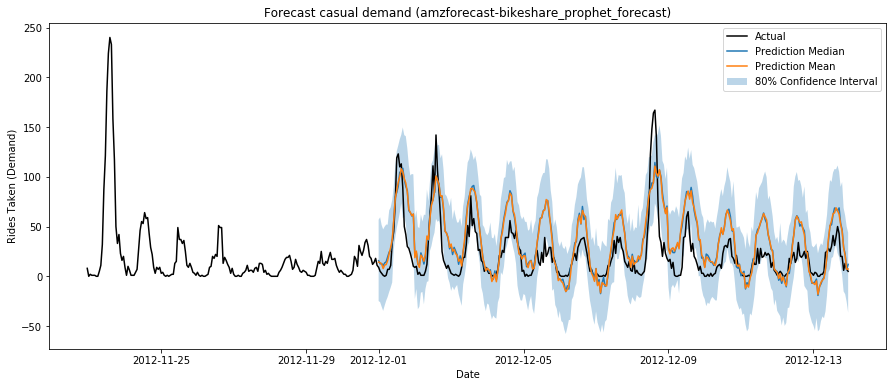

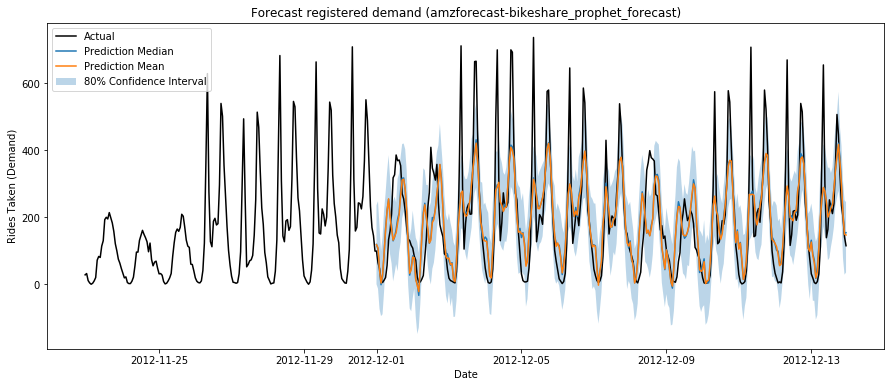

In [66]:
# First, prepare the actual data (training + test) for easy plotting:
first_plot_dt = test_end_dt - timedelta(days=21)
actuals_df = target_train_df.append(target_test_df)
actuals_df["timestamp"] = pd.to_datetime(actuals_df["timestamp"])
actuals_plot_df = actuals_df[
    (actuals_df["timestamp"] >= first_plot_dt)
    & (actuals_df["timestamp"] <= test_end_dt)
]
actuals_plot_df.rename(columns={ "item_id": "customer_type"}, inplace=True)

util.plot_fcst_results(actuals_plot_df, clean_results_df)

통계적인 시계열 예측을 AWS Console에서 수행하였고, 소스코드로 다운로드 받고 처리를 하였습니다. 과학적인 지식이 요구되지 않았으나, 심층적인 작업을 원하는 경우에는 모델의 아키텍처와 하이퍼파라미터를 조정하여 수행해볼 수 있습니다.

**console의 metrics에서 가장 좋은 결과로 평가한 모델과 시각적으로 보여지는 결과가 일치합니까? **

## Extension exercises and exploring further

[Amazon Forecast metrics docs](https://docs.aws.amazon.com/forecast/latest/dg/metrics.html)에서 언급된 수식과 위 시각화를 위한 소스코드 예제를 이용하여 이번 예측 window에 대한 RMSE와 가중 quantile 손실 값을 계산할 수 있습니까? 학습에서 계산한 Amazon Forecast 값과 어떻게 비교를 할까요?

다른 dataset group **domain**에서 더 좋은 성능을 얻을 수 있을까요? 일부 domain의 경우에는 다른 컬럼 이름과 타입을 요구할 수 있기에 더 많은 데이터 작업이 필요할 수 있습니다.


Amazon Forecast에는 내부에서 제공하는 시간 관련 featurization을 가지고 있기 때문에 정확한 절대 timestamp와 날짜가 중요합니다. related timeseries 특성인 `workingday` 제거하는 것은 예측 품질에 많은 영향을 줄까요? `holiday`의 경우는 어떨까요? 추가적으로 전체 데이터셋의 timestamps를 날짜로 변경하면 어떻게 될까요?

## Thanks for joining in! (Clean-up time)

[Amazon Forecast 가격](https://aws.amazon.com/forecast/pricing/) 은 다음과 같습니다.

* 생성된 forecasts
* 데이터 저장
* 학습 시간

따라서, 일부 서비스처럼 삭제에 대해 걱정할 실시간 endpoint 컴퓨팅 리소스는 없습니다. 하지만 데이터 스토리지 비용이 중요한 경우에는 이를 정리할 필요는 있습니다.

Amazon Forecast console을 통해 모든 리소스 (forecasts, predictors, import jobs, 데이터셋과 데이터셋 그룹 등) 를 삭제할 수 있습니다. S3 버킷과 SageMaker로 수행하였다면 notebook instance 를 stop해야 합니다.